In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math


          ds     y
0 2005-01-01  5500
1 2005-02-01  5476
2 2005-03-01  5466
3 2005-04-01  5487
4 2005-05-01  5876

Dataset shape: (249, 2)


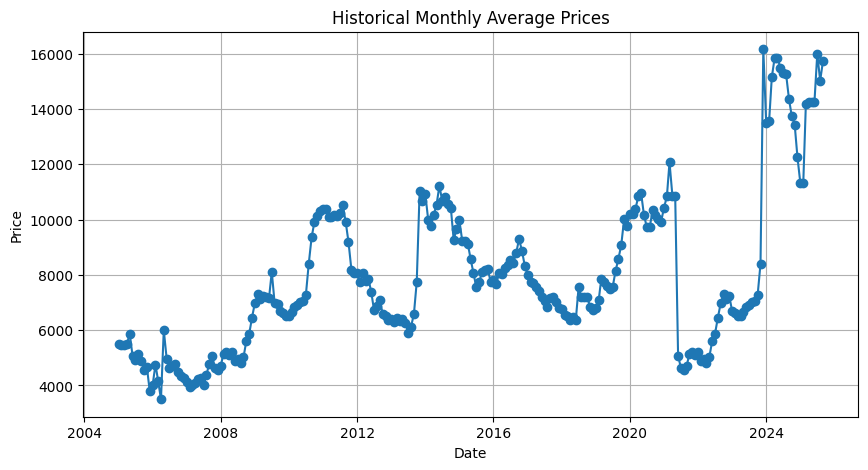

In [6]:
# Load dataset
df = pd.read_csv("price_data.csv")  # 🔁 Replace with your file name

# Detect date and price columns robustly to avoid KeyError
cols = list(df.columns)
date_col = next((c for c in cols if 'date' in c.lower() or 'time' in c.lower()), None)
price_col = next((c for c in cols if any(k in c.lower() for k in ['price','avg','value','y'])), None)
if date_col is None or price_col is None:
    # fallback to first two columns if detection fails
    if len(cols) >= 2:
        date_col, price_col = cols[0], cols[1]
    else:
        raise KeyError('Could not find date and price columns in CSV')

# Rename and parse safely
df = df.rename(columns={date_col: 'ds', price_col: 'y'})
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df = df.dropna(subset=['ds','y']).sort_values('ds').reset_index(drop=True)

# Display basic info
print(df.head())
print("\nDataset shape:", df.shape)

# Plot raw data
plt.figure(figsize=(10,5))
plt.plot(df['ds'], df['y'], marker='o')
plt.title("Historical Monthly Average Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()


In [8]:
# Extract price values
data = df['y'].values.reshape(-1,1)

# Normalize to [0,1] range
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Split into train and test (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [10]:
def create_dataset(dataset, time_step=12):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 12
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (186, 12, 1)
X_test shape: (37, 12, 1)


In [12]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0024 - val_loss: 0.0348
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0024 - val_loss: 0.0348
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - val_loss: 0.0349
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - val_loss: 0.0349
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0362
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0362
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 0.0310
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 0.0310
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0392
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0392
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0352
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss

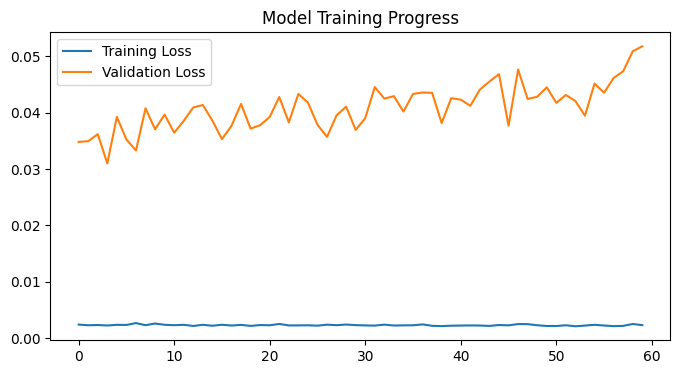

In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=8,
    verbose=1
)

# Plot training loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Training Progress")
plt.legend()
plt.show()


In [16]:
train_predict = model.predict(X_train)
test_predict  = model.predict(X_test)

# Inverse transform to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict  = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_actual  = scaler.inverse_transform(y_test.reshape(-1,1))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [17]:
mae = mean_absolute_error(y_test_actual, test_predict)
rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))
mean_value = np.mean(y_test_actual)
accuracy = 100 - (mae / mean_value) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Approx. Accuracy: {accuracy:.2f}%")


Mean Absolute Error (MAE): 1822.90
Root Mean Squared Error (RMSE): 2880.21
Approx. Accuracy: 83.63%


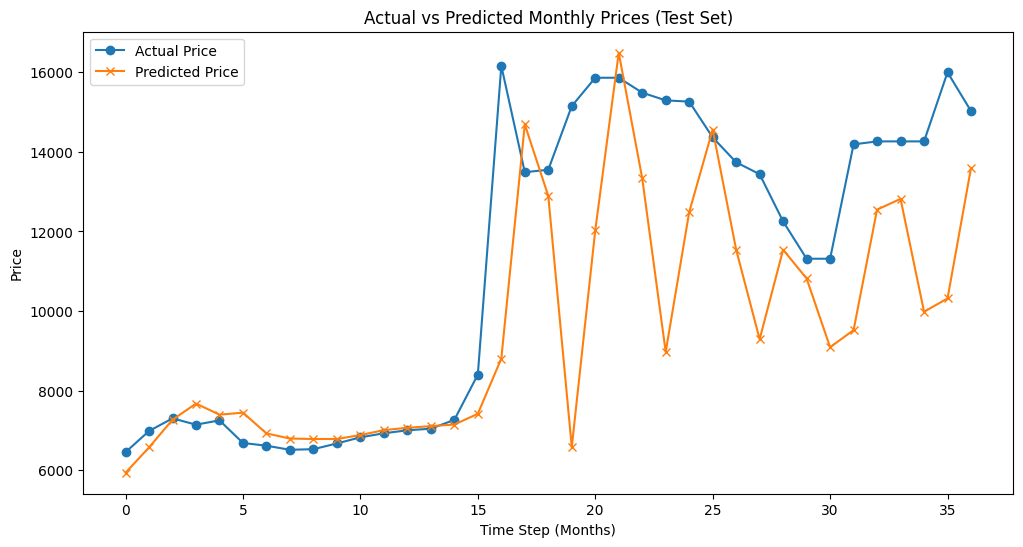

In [18]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price', marker='o')
plt.plot(test_predict, label='Predicted Price', marker='x')
plt.title("Actual vs Predicted Monthly Prices (Test Set)")
plt.xlabel("Time Step (Months)")
plt.ylabel("Price")
plt.legend()
plt.show()


In [19]:
# Start with the last 12 months of data
last_12 = test_data[-time_step:]
future_input = last_12.reshape(1, time_step, 1)

future_predictions = []

for i in range(12):
    next_pred = model.predict(future_input)[0,0]
    future_predictions.append(next_pred)
    
    # Append prediction and remove oldest value
    future_input = np.append(future_input[:,1:,:], [[[next_pred]]], axis=1)

# Inverse transform
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

# Create future date range
last_date = df['ds'].max()
future_dates = pd.date_range(last_date, periods=12, freq='M')

# Combine and display
future_forecast = pd.DataFrame({'ds': future_dates, 'Predicted_Price': future_predictions.flatten()})
print(future_forecast)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
           ds  Predicted_Price
0  2025-09-30     10593.894531
1  2025-10-31      7647.299316
2  2025-11-30      5791.423828
3 

C:\Users\Deekashith Gowda\AppData\Local\Temp\ipykernel_4580\825333200.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date, periods=12, freq='M')


In [20]:
future_forecast.to_csv("LSTM_future_forecast.csv", index=False)
print("✅ Future forecast saved as LSTM_future_forecast.csv")


✅ Future forecast saved as LSTM_future_forecast.csv
